In [31]:
import torch
import gc
import transformers
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertConfig
from transformers import BertForPreTraining, BertForMaskedLM


from tqdm.auto import tqdm
from transformers import AdamW
import numpy as np

In [43]:
mujeres = pd.read_csv("tweets_mujeres.csv",usecols=['id','tweet'])

In [2]:
hombres = pd.read_csv("tweets_hombres.csv",usecols=['id','tweet'])

In [5]:
mujeres.index

RangeIndex(start=0, stop=201038, step=1)

In [6]:
import numpy as np

np.random.seed(10)

remove_n = len(hombres) - len(mujeres)
drop_indices = np.random.choice(hombres.index, remove_n, replace=False)
hombres = hombres.drop(drop_indices)

In [3]:
beto = 'dccuchile/bert-base-spanish-wwm-cased'

tokenizer_h = BertTokenizer.from_pretrained(beto, 
                        return_offset_mapping=True)
model_h = BertForMaskedLM.from_pretrained(beto, return_dict=True)

tokenizer_m = BertTokenizer.from_pretrained(beto, 
                        return_offset_mapping=True)
model_m = BertForMaskedLM.from_pretrained(beto, return_dict=True)




Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

In [5]:
len(hombres)

201038

In [6]:
tokenizer_h

PreTrainedTokenizer(name_or_path='dccuchile/bert-base-spanish-wwm-cased', vocab_size=31002, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [7]:
def preprocess_function_mujeres(examples):
    inputs = [ex for ex in examples["mujeres_tweet"]]
    #targets = [ex for ex in examples["hombres_tweet"]]

    model_inputs = tokenizer_m(inputs,
                        #text_pair=targets,
                        padding="max_length", 
                        truncation=True,
                        max_length=280,
                        return_tensors='pt'
                        )
    return model_inputs


def preprocess_function_hombres(examples):
    #inputs = [ex for ex in examples["mujeres_tweet"]]
    inputs = [ex for ex in examples["hombres_tweet"]]

    model_inputs = tokenizer_h(inputs,
                        #text_pair=targets,
                        padding="max_length", 
                        truncation=True,
                        max_length=280,
                        return_tensors='pt'
                        )
    return model_inputs

In [8]:
def tokenize_sentences_mujeres(mujeres):
    data = {"mujeres_tweet":list(mujeres.tweet)
        #"hombres_tweet":list(hombres.tweet)
           }
    raw_dataset = pd.DataFrame(data)

    ds = Dataset.from_pandas(raw_dataset,preserve_index=True)
    ds = ds.rename_column('__index_level_0__','id')
    ds = ds.train_test_split(shuffle = True, seed = 200, test_size=0.2)

    train_set = preprocess_function_mujeres(ds["train"])
    test_set = preprocess_function_mujeres(ds["test"])
    
    train_set['labels'] = train_set['input_ids'].detach().clone()
    test_set['labels'] = test_set['input_ids'].detach().clone()
    
    return train_set, test_set
            
            
def tokenize_sentences_hombres(hombres):
    data = {#"mujeres_tweet":list(mujeres.tweet),
        "hombres_tweet":list(hombres.tweet)}
    raw_dataset = pd.DataFrame(data)

    ds = Dataset.from_pandas(raw_dataset,preserve_index=True)
    ds = ds.rename_column('__index_level_0__','id')
    ds = ds.train_test_split(shuffle = True, seed = 200, test_size=0.2)

    train_set = preprocess_function_hombres(ds["train"])
    test_set = preprocess_function_hombres(ds["test"])
    
    train_set['labels'] = train_set['input_ids'].detach().clone()
    test_set['labels'] = test_set['input_ids'].detach().clone()
    
    return train_set, test_set

In [19]:
trainingSet_mujeres, testSet_mujeres= tokenize_sentences_mujeres(mujeres)

In [9]:
trainingSet_hombres, testSet_hombres= tokenize_sentences_hombres(hombres)

# Haciendo BETO para mujeres

In [21]:
input_ids = trainingSet_mujeres["input_ids"]
input_ids[0][7] = tokenizer_m.mask_token_id

labels = trainingSet_mujeres["input_ids"].clone()
labels[labels!= tokenizer_m.mask_token_id] = -100

In [12]:
class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }

In [23]:
dataset_mujeres = TweetsDataset(trainingSet_mujeres)

In [24]:
input_ids = testSet_mujeres["input_ids"]
input_ids[0][7] = tokenizer_m.mask_token_id

labels = testSet_mujeres["input_ids"].clone()
labels[labels!= tokenizer_m.mask_token_id] = -100

In [13]:
class TweetsDataset2(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }

In [26]:
test_dataset_mujeres = TweetsDataset2(testSet_mujeres)

In [14]:
def get_dataloader(dataset_mujeres):
    dataloader = torch.utils.data.DataLoader(
      dataset_mujeres,
      batch_size=32,
      shuffle=True,
    num_workers=5
    )
    return dataloader

def get_Testdataloader(test_dataset_mujeres):
    dataloader = torch.utils.data.DataLoader(
      test_dataset_mujeres,
      batch_size=16,
      shuffle=True,
    num_workers=5
    )
    return dataloader

In [28]:
Data_loader_train_mujeres = get_dataloader(dataset_mujeres)
Data_loader_test_mujeres = get_Testdataloader(test_dataset_mujeres)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [31]:
model_m.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [33]:
from tqdm.auto import tqdm
from transformers import AdamW
from transformers import DataCollatorForLanguageModeling

In [35]:
epochs = 3
optimizer = torch.optim.AdamW(model_m.parameters(), lr=3e-5)

In [36]:
gc.collect()

487

In [37]:
torch.cuda.empty_cache()

In [38]:
def compute_metrics(pred):
    corr = torch.corrcoef(pred)
    return corr.item()

In [107]:
def training(Data_loader_train_mujeres):
    global losses_list_train
    global perplexity_list_train
    
    losses_list_train = []
    perplexity_list_train = []
    
    model_m.train()
    
    loop = tqdm(Data_loader_train_mujeres)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        outputs = model_m(input_ids=input_ids,
                        labels=labels,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        loss = outputs.loss
        x = outputs.logits
        loss.backward()
        optimizer.step()
        
        try:
            perplexity = torch.exp(loss)
        except OverflowError:
            perplexity = torch.tensor(float("inf"))
        corr = compute_metrics(x.view(-1))

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item(), corr = corr, perplexity=perplexity.item())
        
        losses_list_train.append(loss.item())
        perplexity_list_train.append(perplexity.item())
    return outputs

def test(Data_loader_test_mujeres):
    global losses_list_test
    global perplexity_list_test
    
    losses_list_test = []
    perplexity_list_test = []
    
    model_m.eval()
    loop = tqdm(Data_loader_test_mujeres)
    
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        outputs = model_m(input_ids=input_ids,
                        labels=labels,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        try:
            perplexity = torch.exp(loss)
        except OverflowError:
            perplexity = torch.tensor(float("inf"))
        
        x = outputs.logits
        corr = compute_metrics(x.view(-1))

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item(), corr=corr, perplexity= perplexity.item())
        
        losses_list_test.append(loss.item())
        perplexity_list_test.append(perplexity.item())
    return outputs

In [108]:
df_metrics = pd.DataFrame(columns=["stage","loss","perplexity"])

In [109]:
dic = {"stage":[],"loss":[],"perplexity":[]}

In [110]:
for epoch in range(epochs):
    print("Collect gc")
    gc.collect()
    print("Empty cache")
    torch.cuda.empty_cache()
    
    print("Training BETO")
    training(Data_loader_train_mujeres)
    
    print("Saving train metrics...")
    
    dic["stage"].append(["training " +str(epoch)])
    dic["loss"].append([losses_list_train])
    dic["perplexity"].append([perplexity_list_train])
    
    
    print("Collect gc")
    gc.collect()
    print("Empty cache")
    torch.cuda.empty_cache()
    
    
    print("Test phase")
    test(Data_loader_test_mujeres)
    
    print("Saving test metrics...")
    dic["stage"].append(["testing " +str(epoch)])
    dic["loss"].append([losses_list_test])
    dic["perplexity"].append([perplexity_list_test])
    

Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...
Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...
Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...


In [112]:
model_m.save_pretrained('./my_model_checkpoints_ellas/')

In [113]:
tokenizer_m.save_pretrained('./my_model_checkpoints_ellas/')

('./my_model_checkpoints_ellas/tokenizer_config.json',
 './my_model_checkpoints_ellas/special_tokens_map.json',
 './my_model_checkpoints_ellas/vocab.txt',
 './my_model_checkpoints_ellas/added_tokens.json')

In [114]:
mujeres.tweet.to_numpy()[0]

'@adams_zulema Muchas gracias @adams_zulema ❤️ saludos'

In [34]:
import numpy as np
def encode(df):
    data = df.tweet.to_numpy()
    print("Encoding the corpus. This might take a while")
    embeddings = []
    for sentence in data:
        corpus_embeddings = tokenizer_m.encode(sentence)
        corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings,keepdims=True)
        embeddings.append(corpus_embeddings)
        
    return embeddings

In [44]:
mujeres_embeddings = encode(mujeres)

Encoding the corpus. This might take a while


In [46]:
datos_encoded = pd.DataFrame([mujeres_embeddings]).T
datos_encoded

,0
0,"[7.385955842880247e-05, 0.017874013139770197, ..."
1,"[9.696918678311202e-05, 0.023466543201513108, ..."
2,"[0.00010317742993578228, 0.02496893804445931, ..."
3,"[8.26033209166283e-05, 0.01999000366182405, 0...."
4,"[7.263852859362213e-05, 0.017578523919656554, ..."
...,...
201033,"[0.00013164971493361398, 0.031859231013934584,..."
201034,"[4.920264342492051e-05, 0.011907039708830763, ..."
201035,"[9.18747303854724e-05, 0.02223368475328432, 0...."
201036,"[6.743462017929525e-05, 0.01631917808338945, 0..."


In [40]:
#datos_encoded.columns = ["Mujeres"]

In [41]:
model_m = BertForMaskedLM.from_pretrained('./my_model_checkpoints_ellas/', return_dict=True)

tokenizer_m = BertTokenizer.from_pretrained('./my_model_checkpoints_ellas/', 
                        return_offset_mapping=True)

In [42]:
model_m.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [47]:
datos_encoded.to_csv("./my_model_checkpoints_ellas/embeddings.csv")

# Haciendo BETO para hombres

In [10]:
input_ids = trainingSet_hombres["input_ids"]
input_ids[0][7] = tokenizer_h.mask_token_id

labels = trainingSet_hombres["input_ids"].clone()
labels[labels!= tokenizer_h.mask_token_id] = -100

In [15]:
dataset_hombres = TweetsDataset(trainingSet_hombres)

In [16]:
input_ids = testSet_hombres["input_ids"]
input_ids[0][7] = tokenizer_h.mask_token_id

labels = testSet_hombres["input_ids"].clone()
labels[labels!= tokenizer_h.mask_token_id] = -100

In [17]:
test_dataset_hombres = TweetsDataset2(testSet_hombres)

In [18]:
def get_dataloader(dataset_hombres):
    dataloader = torch.utils.data.DataLoader(
      dataset_hombres,
      batch_size=32,
      shuffle=True,
    num_workers=5
    )
    return dataloader

def get_Testdataloader(test_dataset_hombres):
    dataloader = torch.utils.data.DataLoader(
      test_dataset_hombres,
      batch_size=16,
      shuffle=True,
    num_workers=5
    )
    return dataloader

In [19]:
Data_loader_train_hombres = get_dataloader(dataset_hombres)
Data_loader_test_hombres = get_Testdataloader(test_dataset_hombres)

In [20]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
model_h.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [24]:
epochs = 3
optimizer = torch.optim.AdamW(model_h.parameters(), lr=3e-5)

In [25]:
gc.collect()
torch.cuda.empty_cache()

In [26]:
def compute_metrics(pred):
    corr = torch.corrcoef(pred)
    return corr.item()

In [27]:
def training(Data_loader_train_hombres):
    global losses_list_train
    global perplexity_list_train
    
    losses_list_train = []
    perplexity_list_train = []
    
    model_h.train()
    
    loop = tqdm(Data_loader_train_hombres)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        outputs = model_h(input_ids=input_ids,
                        labels=labels,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        loss = outputs.loss
        x = outputs.logits
        loss.backward()
        optimizer.step()
        
        try:
            perplexity = torch.exp(loss)
        except OverflowError:
            perplexity = torch.tensor(float("inf"))
        corr = compute_metrics(x.view(-1))

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item(), corr = corr, perplexity=perplexity.item())
        
        losses_list_train.append(loss.item())
        perplexity_list_train.append(perplexity.item())
    return outputs

In [28]:
def test(Data_loader_test_hombres):
    global losses_list_test
    global perplexity_list_test
    
    losses_list_test = []
    perplexity_list_test = []
    
    model_h.eval()
    loop = tqdm(Data_loader_test_hombres)
    
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        outputs = model_h(input_ids=input_ids,
                        labels=labels,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        try:
            perplexity = torch.exp(loss)
        except OverflowError:
            perplexity = torch.tensor(float("inf"))
        
        x = outputs.logits
        corr = compute_metrics(x.view(-1))

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item(), corr=corr, perplexity= perplexity.item())
        
        losses_list_test.append(loss.item())
        perplexity_list_test.append(perplexity.item())
    return outputs

In [29]:
dic2 = {"stage":[],"loss":[],"perplexity":[]}

In [32]:
for epoch in range(epochs):
    print("Collect gc")
    gc.collect()
    print("Empty cache")
    torch.cuda.empty_cache()
    
    print("Training BETO")
    training(Data_loader_train_hombres)
    
    print("Saving train metrics...")
    
    dic2["stage"].append(["training " +str(epoch)])
    dic2["loss"].append([losses_list_train])
    dic2["perplexity"].append([perplexity_list_train])
    
    
    print("Collect gc")
    gc.collect()
    print("Empty cache")
    torch.cuda.empty_cache()
    
    
    print("Test phase")
    test(Data_loader_test_hombres)
    
    print("Saving test metrics...")
    dic2["stage"].append(["testing " +str(epoch)])
    dic2["loss"].append([losses_list_test])
    dic2["perplexity"].append([perplexity_list_test])

Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...
Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...
Collect gc
Empty cache
Training BETO


  0%|          | 0/5026 [00:00<?, ?it/s]

Saving train metrics...
Collect gc
Empty cache
Test phase


  0%|          | 0/2513 [00:00<?, ?it/s]

Saving test metrics...


In [33]:
model_h.save_pretrained('./my_model_checkpoints_ellos/')
tokenizer_h.save_pretrained('./my_model_checkpoints_ellos/')

('./my_model_checkpoints_ellos/tokenizer_config.json',
 './my_model_checkpoints_ellos/special_tokens_map.json',
 './my_model_checkpoints_ellos/vocab.txt',
 './my_model_checkpoints_ellos/added_tokens.json')

In [48]:
def encode_h(df):
    data = df.tweet.to_numpy()
    print("Encoding the corpus. This might take a while")
    embeddings = []
    for sentence in data:
        corpus_embeddings = tokenizer_h.encode(sentence)
        corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings,keepdims=True)
        embeddings.append(corpus_embeddings)
        
    return embeddings

In [49]:
hombres_embeddings = encode_h(hombres)
datos_encoded_h = pd.DataFrame([hombres_embeddings]).T
datos_encoded_h

Encoding the corpus. This might take a while


,0
0,"[3.816494920055965e-05, 0.009235917706535436, ..."
1,"[6.713648515312846e-05, 0.016247029407057086, ..."
2,"[7.366200808377754e-05, 0.03773336364091505, 0..."
3,"[4.6868850776566485e-05, 0.011342261887929089,..."
4,"[6.414600809947812e-05, 0.015523333960073707, ..."
...,...
201033,"[0.00018326758470886816, 0.0443507554995461, 0..."
201034,"[6.968833640671187e-05, 0.01686457741042427, 0..."
201035,"[2.3147376717439104e-05, 0.005601665165620264,..."
201036,"[6.332127941230833e-05, 0.015323749617778614, ..."


In [50]:
datos_encoded_h.to_csv("./my_model_checkpoints_ellos/embeddings.csv")

In [56]:
df_metrics = pd.DataFrame(dic2)

In [53]:
import matplotlib.pyplot as plt

In [58]:
seq = list(df_metrics.loss)

In [79]:
a = []
for i in seq[0]:
    a.append(i)

In [82]:
b = []
for i in a[0]:
    b.append(i)

In [83]:
len(b)

5026

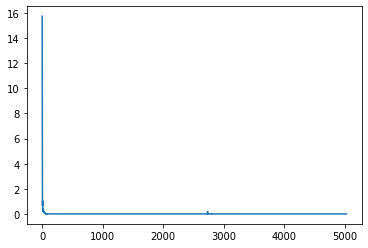

In [84]:
plt.plot(b)